# Kidney Disease Classification Model

3-class neural network: Normal / Microalbuminuria / Macroalbuminuria

## 1. Imports

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
print(f'PyTorch: {torch.__version__}')

PyTorch: 2.9.1+cpu


## 2. Configuration

In [47]:
CLASS_NAMES = ['Normal', 'Microalbuminuria', 'Macroalbuminuria']
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 200
PATIENCE = 15

## 3. Load Data

In [48]:
df = pd.read_csv('datasets/combined_data.csv')
print(f'Shape: {df.shape}')
print(df['data_type'].value_counts())

Shape: (34097, 39)
data_type
training    26762
testing      7335
Name: count, dtype: int64


In [49]:
target_col = 'albuminuria_risk'
exclude_cols = ['albuminuria_risk', 'liver_dysfunction', 'has_cardiovascular_disease',
                'high_waist_circumference', 'high_triglycerides_mg_dl', 'low_hdl_mg_dl',
                'high_blood_pressure', 'high_glucose_mg_dl', 'data_type']
feature_cols = [c for c in df.columns if c not in exclude_cols]
print(f'Features: {len(feature_cols)}')

Features: 30


In [50]:
print('Class Distribution:')
for idx, count in df[target_col].value_counts().sort_index().items():
    print(f'  {CLASS_NAMES[int(idx)]}: {count} ({count/len(df)*100:.1f}%)')

Class Distribution:
  Normal: 26217 (76.9%)
  Microalbuminuria: 3265 (9.6%)
  Macroalbuminuria: 689 (2.0%)


## 4. Prepare Data

In [51]:
df = df.dropna(subset=[target_col])
X = df[feature_cols].fillna(0).values.astype(np.float32)
y = df[target_col].values.astype(np.int64)
data_types = df['data_type'].values

X_train, y_train = X[data_types=='training'], y[data_types=='training']
X_test, y_test = X[data_types=='testing'], y[data_types=='testing']

X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train)
X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test)

print(f'Train: {len(X_train)}, Test: {len(X_test)}, Features: {X_train.shape[1]}')

Train: 23284, Test: 6887, Features: 30


In [52]:
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

class_counts = np.bincount(y_train)
class_weights = torch.tensor(len(y_train) / (len(class_counts) * class_counts), dtype=torch.float32)
print(f'Class weights: {class_weights.numpy()}')

Class weights: [ 0.37793794  3.431182   15.969822  ]


## 5. Model

In [53]:
class KidneyMLP(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, num_classes)
        self.drop = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.drop(torch.relu(self.bn1(self.fc1(x))))
        x = self.drop(torch.relu(self.bn2(self.fc2(x))))
        x = self.drop(torch.relu(self.bn3(self.fc3(x))))
        return self.fc4(x)

model = KidneyMLP(X_train.shape[1])
print(model)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

KidneyMLP(
  (fc1): Linear(in_features=30, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)
Parameters: 14,851


## 6. Training

In [54]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses, val_accs = [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for bx, by in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(bx), by)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_loader))
    
    model.eval()
    with torch.no_grad():
        val_out = model(X_test_t)
        val_loss = criterion(val_out, y_test_t).item()
        val_losses.append(val_loss)
        val_acc = (val_out.argmax(1) == y_test_t).float().mean().item()
        val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1:3d} | Train: {train_losses[-1]:.4f} | Val: {val_loss:.4f} | Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break

print('Training complete!')

Epoch  10 | Train: 0.8860 | Val: 0.9849 | Acc: 0.6123
Early stopping at epoch 16
Training complete!


## 7. Training Curves

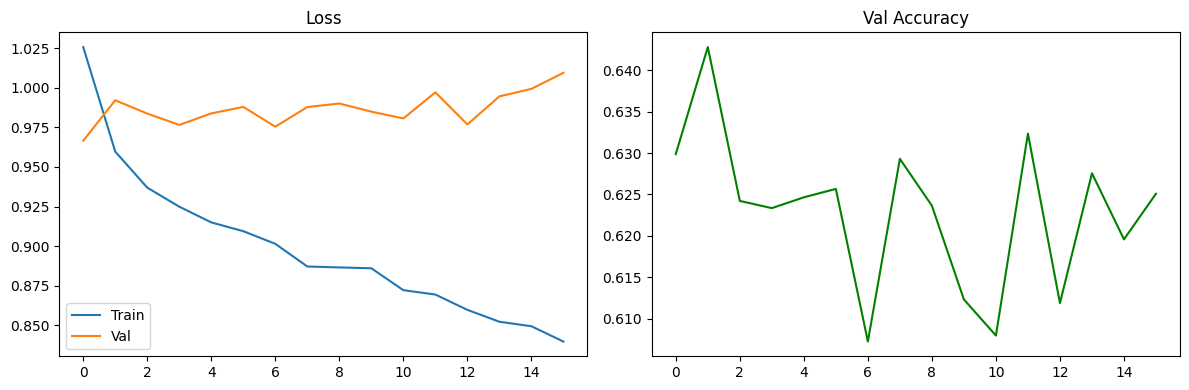

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_losses, label='Train')
ax[0].plot(val_losses, label='Val')
ax[0].set_title('Loss'); ax[0].legend()
ax[1].plot(val_accs, color='green')
ax[1].set_title('Val Accuracy')
plt.tight_layout()
plt.show()

## 8. Evaluation

In [56]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

with torch.no_grad():
    out = model(X_test_t)
    probs = torch.softmax(out, 1)
    preds = out.argmax(1)

y_true = y_test_t.numpy()
y_pred = preds.numpy()

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print('='*50)
print('RESULTS')
print('='*50)
print(f'Accuracy:  {acc:.4f} ({acc*100:.2f}%)')
print(f'Precision: {prec:.4f}')
print(f'Recall:    {rec:.4f}')
print(f'F1-Score:  {f1:.4f}')

RESULTS
Accuracy:  0.6299 (62.99%)
Precision: 0.7663
Recall:    0.6299
F1-Score:  0.6815


In [57]:
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

                  precision    recall  f1-score   support

          Normal       0.89      0.69      0.78      5681
Microalbuminuria       0.20      0.32      0.24      1003
Macroalbuminuria       0.13      0.56      0.21       203

        accuracy                           0.63      6887
       macro avg       0.41      0.52      0.41      6887
    weighted avg       0.77      0.63      0.68      6887



## 9. Confusion Matrix

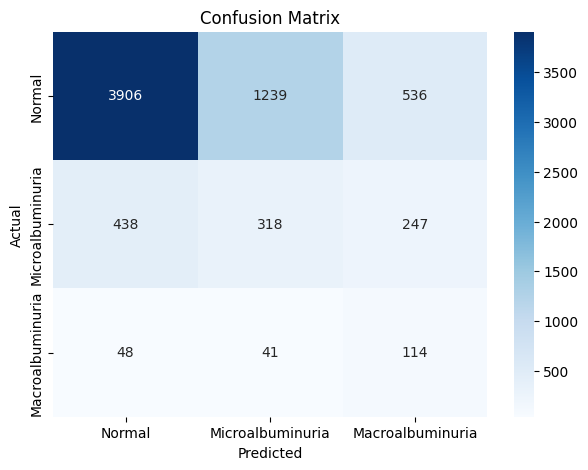

In [58]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 10. ROC Curves

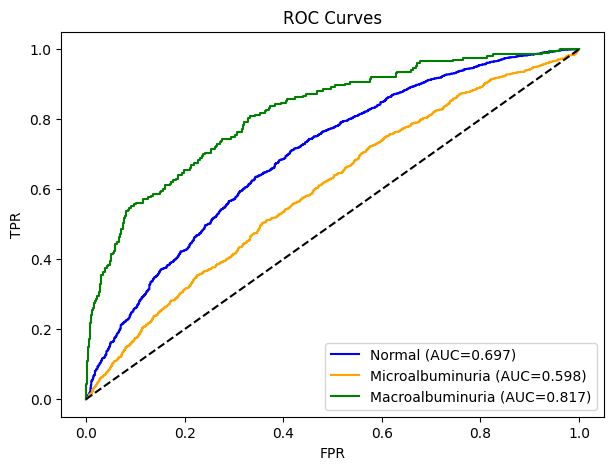

In [59]:
y_bin = label_binarize(y_true, classes=[0,1,2])
y_probs = probs.numpy()

plt.figure(figsize=(7, 5))
for i, (name, c) in enumerate(zip(CLASS_NAMES, ['blue','orange','green'])):
    if y_bin[:,i].sum() > 0:
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_probs[:,i])
        auc = roc_auc_score(y_bin[:,i], y_probs[:,i])
        plt.plot(fpr, tpr, c, label=f'{name} (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curves'); plt.legend()
plt.show()